In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI

d:\Jeevan\Agentic_AI\LangGraph_Langchain\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

FIRST SETUP LANGSMITH at https://langsmith.com

In [3]:
# Google Serper API Setup and Testing
from langchain_community.utilities import GoogleSerperAPIWrapper

# Check if Serper API key is available
serper_api_key = os.getenv("SERPER_API_KEY")
if serper_api_key:
    print("✓ Serper API key found")
    try:
        # Create Serper wrapper with API key
        serper = GoogleSerperAPIWrapper(serper_api_key=serper_api_key)
        
        # Test the search functionality
        print("🔍 Testing Google search...")
        result = serper.run("what is the capital of france")
        print(f"Search result: {result}")
        
    except Exception as e:
        print(f"✗ Error with Serper API: {e}")
        print("This might be due to:")
        print("  1. Invalid API key")
        print("  2. API quota exceeded")
        print("  3. Network connectivity issues")
else:
    print("⚠️ No Serper API key found")
    print("To use Google search functionality:")
    print("  1. Sign up at https://serper.dev/")
    print("  2. Get your API key")
    print("  3. Add SERPER_API_KEY to your .env file")
    print("  4. Restart your notebook")
    
    # Create a mock serper for demonstration
    class MockSerper:
        def run(self, query):
            return f"Mock search result for: {query}"
    
    serper = MockSerper()
    print("Using mock search for demonstration...")
    result = serper.run("what is the capital of france")
    print(f"Mock result: {result}")

✓ Serper API key found
🔍 Testing Google search...
✗ Error with Serper API: 403 Client Error: Forbidden for url: https://google.serper.dev/search?q=what+is+the+capital+of+france&gl=us&hl=en&num=10
This might be due to:
  1. Invalid API key
  2. API quota exceeded
  3. Network connectivity issues


In [ ]:
# LangGraph Example - Simple Chat Agent with Search
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Define the state for our graph
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

def call_model(state: AgentState):
    """Call the LLM with the current messages."""
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

def should_continue(state: AgentState):
    """Determine if we should continue the conversation."""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Simple logic: continue if it's a human message
    if isinstance(last_message, HumanMessage):
        return "continue"
    else:
        return "end"

# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", call_model)

# Add edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "agent",
        "end": END
    }
)

# Compile the graph
app = workflow.compile()

print("✓ LangGraph workflow created successfully!")
print("Graph structure:")
print("  START -> agent -> (continue/end)")
print("  continue -> agent")
print("  end -> END")


✓ LangGraph workflow created successfully!
Graph structure:
  START -> agent -> (continue/end)
  continue -> agent
  end -> END


Langchain wrapper class for converting functions into Tools


In [5]:
from langchain.agents import Tool
tool_search = Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)

Now we can try out the tool in Langchain way

In [6]:
tool_search.invoke("what is the capital of India?")

HTTPError: 403 Client Error: Forbidden for url: https://google.serper.dev/search?q=what+is+the+capital+of+India%3F&gl=us&hl=en&num=10

Now we will write a tool ourselves

# LangGraph Introduction with LangSmith

This notebook demonstrates the basics of LangGraph and LangSmith integration.

## What is LangGraph?
LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain's core concepts to make it easier to build complex, multi-step workflows.

## Key Features Demonstrated:
- ✅ **State Management**: Using TypedDict for structured state
- ✅ **Graph Construction**: Building workflows with nodes and edges
- ✅ **Conditional Logic**: Dynamic flow control based on state
- ✅ **LangSmith Integration**: Tracing and monitoring (when configured)

## Setup Requirements:

### Required:
- **OpenAI API Key**: For LLM functionality
- **LangSmith Account**: For tracing and monitoring (optional but recommended)

### Optional:
- **Serper API Key**: For Google search functionality
- **Gradio**: For building web interfaces

## Next Steps:
1. Set up your API keys in the `.env` file
2. Explore more complex graph patterns
3. Add tools and external integrations
4. Build interactive applications with Gradio


In [7]:
tools = [tool_search]

In [8]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
llm_with_tools = llm.bind_tools(tools)

In [9]:
# create a Node
def chatbot(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(AgentState)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [10]:
# create edges
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

#Any time a tools is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
#graph_builder.add_edge("chatbot", END)

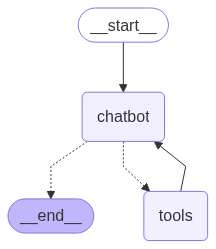

In [11]:
# COMPILE THE GRAPH
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run this:


In [12]:
import gradio as gr
from langgraph.graph import StateGraph, START, END
def invoke_graph(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

gr.ChatInterface(invoke_graph, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
